In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from google.colab import auth
auth.authenticate_user()

In [3]:
!gcloud config set project objectdetection-229309

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud alpha survey



#...

In [4]:
!git clone https://github.com/tensorflow/models.git /content/tf
!cd /content/tf/research; protoc object_detection/protos/*.proto --python_out=.
!cd /content/tf/research; export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim; python /content/tf/research/object_detection/builders/model_builder_test.py

Cloning into '/content/tf'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 27498 (delta 17), reused 18 (delta 9), pack-reused 27466
Receiving objects: 100% (27498/27498), 509.07 MiB | 33.75 MiB/s, done.
Resolving deltas: 100% (16805/16805), done.
Checking out files: 100% (2986/2986), done.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

............s...
----------------------------------------------------------------------
Ran 16 tests in 0.096s

OK (skipped=1)


In [0]:
import sys
sys.path.append('tf/research')
sys.path.append('tf/research/slim')

# ...

In [0]:
from bs4 import BeautifulSoup
from object_detection.utils import label_map_util

id_index = label_map_util.create_category_index_from_labelmap("/content/gdrive/My Drive/Masterarbeit/ObjectDetection/LabelMaps/2019_5_28_9_24_26.pbtxt")
name_index = {i["name"]: i for i in id_index.values() }


def load_annotation(file_path):
  """
  Load annotation file for a given image and parse xml to dict.
  Args:
    img_name: string of the image name.
    infos: dict with information that should be appended to image dict
  Returns:
    dict of the image with all infos
  """
  xml = ""
  with open(file_path, 'r') as f:
    xml = f.readlines()
  xml = ''.join([line.strip('\t') for line in xml])
  bs = BeautifulSoup(xml)
  width = int(bs.size.width.string)
  height = int(bs.size.height.string)
  objects = []
  for ob in bs.find_all("object"):
    name = ob.find('name').string.replace("\n","").replace("\t","").replace(" ","")
    if name in name_index:
      obj = {"name": name,
             "id": name_index[name]["id"],
             "bndbox":{"xmin": int(ob.bndbox.xmin.string) / width,
                       "xmax": int(ob.bndbox.xmax.string) / width,
                       "ymin": int(ob.bndbox.ymin.string) / height,
                       "ymax": int(ob.bndbox.ymax.string) / height}}
      objects.append(obj)
  return objects

In [0]:
def resize_scaled_with_bndboxes(image, objects_old, max_length):
  """resize the image and the bounding boxes accordingly
  It checks if a resized image already exists and otherwise
  creates one. the boundingbox coordinates are normalized
  for calculated since they need to be normalized later on
  anyway.
  Args:
    width_old: the old width
    height_old: the old height
    filepath_old: the old filepath
    bndboxs: a list of bounding boxes
    max_length = the size in pixel of the longest side
  Returns:
    width: the new width
    length: the new length
    filepath: the new filepath
    bndboxs: the new boundingboxes
    
  """
  height_old, width_old = image.shape[:-1]
  
  #find a scaler from the longest side and resize the image
  if width_old > height_old:
    scaler = width_old / max_length
  else:
    scaler = height_old / max_length
  
  height = int(height_old / scaler) 
  width = int(width_old / scaler)
  image = cv2.resize(image, (width,height))
  
  objects = []
  for obj in objects_old:
    bndbox = obj["bndbox"]
    n = {}
    n["xmin"] = bndbox["xmin"]
    n["xmax"] = bndbox["xmax"]
    n["ymin"] = bndbox["ymin"]
    n["ymax"] = bndbox["ymax"]
    
    store = True
    for key, val in n.items():
      if val > 1.0:
        if val - 1 > 0.5:
          store = False
        else:
          n[key] = 1.0
      if val < 0.0:
        if val + 0.5 < 0.0:
          store = False
        else:
          n[key] = 0.0

    if store:
      objects.append({})
      objects[-1]["bndbox"] = n
      objects[-1]["name"] = obj["name"]
      objects[-1]["id"] = obj["id"]
  
  return image, objects

In [0]:
def resize_padded_with_bndboxes(image_old, objects_old, length):
  """resizes the image ot a squared padded image. Where the longest
  side will match their target length. The other dimension is padded
  equally on both sides with zeros until it as well matches length.
  Args:
    width_old: the old width
    height_old: the old height
    filepath_old: the old filepath
    bndboxs: a list of bounding boxes
    length: target length
  Returns:
    width: the new width
    length: the new length
    filepath: the new filepath
    bndboxs: the new boundingboxes
  """
  #First resize the image
  image_old, objects_old = resize_scaled_with_bndboxes(image_old,
                                                       objects_old,
                                                       length)
  
  height_old, width_old = image_old.shape[:-1]
  
  #necessary padding, handle uneven numbers
  pad_x = 0
  pad_y = 0
  if height_old < length:
    pad_size = length - height_old
    pad_x = int(pad_size/2)
  if width_old < length:
    pad_size = length - width_old
    pad_y = int(pad_size/2)
  
  #create empty image array and embedd the image in it
  image = np.zeros([length, length, 3])
  image[pad_x:(pad_x + height_old), pad_y:(pad_y + width_old), :] = image_old
  
  #redo boundingboxes
  objects = []
  for obj in objects_old:
    bndbox = obj["bndbox"]
    n = {}
    n["xmin"] = (bndbox["xmin"] * width_old + pad_y) / float(length)
    n["xmax"] = (bndbox["xmax"] * width_old + pad_y) / float(length)
    n["ymin"] = (bndbox["ymin"] * height_old  + pad_x) / float(length)
    n["ymax"] = (bndbox["ymax"] * height_old  + pad_x) / float(length)
    
    store = True
    for key, val in n.items():
      if val > 1.0:
        if val - 1 > 0.5:
          store = False
        else:
          n[key] = 1.0
      if val < 0.0:
        if val + 0.5 < 0.0:
          store = False
        else:
          n[key] = 0.0

    if store:
      objects.append({})
      objects[-1]["bndbox"] = n
      objects[-1]["name"] = obj["name"]
      objects[-1]["id"] = obj["id"]
  
  return image, objects

In [0]:
import cv2
import numpy as np

def img_2_img_T(img_prev, img_curr, T_curr=np.eye(3)[:2,:]):
  
  prev_gray = cv2.cvtColor(img_prev.astype(np.uint8), cv2.COLOR_BGR2GRAY)  
  prev_pts = cv2.goodFeaturesToTrack(prev_gray,
                                     maxCorners = 100,
                                     qualityLevel = 0.3,
                                     minDistance = 7,
                                     blockSize = 7)

  # Convert to grayscale
  curr_gray = cv2.cvtColor(img_curr.astype(np.uint8), cv2.COLOR_BGR2GRAY) 

  # Calculate optical flow (i.e. track feature points)
  curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None) 

  # Sanity check
  assert prev_pts.shape == curr_pts.shape 

  # Filter only valid points
  idx = np.where(status==1)[0]
  prev_pts = prev_pts[idx]
  curr_pts = curr_pts[idx]

  #Find transformation matrix
  Tcurr_eye = np.eye(3)
  Tcurr_eye[:2,:] = cv2.estimateRigidTransform(prev_pts, curr_pts, fullAffine=False)
  Tprev_eye = np.eye(3)
  Tprev_eye[:2,:] = T_curr
  
  return np.dot(Tcurr_eye,Tprev_eye)[:2,:]

In [0]:
def adjust_boxes_frame_by_frame(objects, height, width, T):
  """Takes the boxes from one frame and a
  4D transformation matrix, and transforms
  the position of the boxes
  """
  
  # x = T11 * x + T12 * y + T13
  # y = T21 * x + T22 * y + T23
  
  for obj in objects:
    box = obj["bndbox"]
    pmin = np.array([box["xmin"] * width, box["ymin"] * height, 1])
    pmax = np.array([box["xmax"] * width, box["ymax"] * height, 1])
    pmin_n = np.dot(T,pmin)
    pmax_n = np.dot(T,pmax)
    box["xmin"] = pmin_n[0] / width
    box["ymin"] = pmin_n[1] / height
    box["xmax"] = pmax_n[0] / width
    box["ymax"] = pmax_n[1] / height
    
  return objects

In [0]:
from object_detection.utils import visualization_utils
import collections
import random

def draw_per_frame(image, boxes, classes):
  """for each image draw the boxes and the labels, with the color according
  to the nutriscore
  
  """
  boxes = np.reshape(boxes,[int(len(classes)),4])
  classes = np.squeeze(classes).astype(np.int32)
  use_normalized_coordinates=True
  line_thickness=6
  nutri_colors = ["Green", "LimeGreen", "Yellow", "Orange", "Red"]
  box_to_display_str_map = collections.defaultdict(list)
  box_to_color_map = collections.defaultdict(str)
  for i in range(0, boxes.shape[0]):
    box = tuple(boxes[i].tolist())
    display_str = '{}'.format(classes[i])
    box_to_color_map[box] = nutri_colors[random.randint(0,4)]
    box_to_display_str_map[box].append(display_str)
    
  image_cp = np.array(image)
    
  # Draw all boxes onto image.
  for box, color in box_to_color_map.items():
    ymin, xmin, ymax, xmax = box
    visualization_utils.draw_bounding_box_on_image_array(
        image_cp,
        ymin,
        xmin,
        ymax,
        xmax,
        color=color,
        thickness=line_thickness,
        display_str_list=box_to_display_str_map[box],
        use_normalized_coordinates=use_normalized_coordinates)

  return image_cp

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt

def show_img(image):
  """ Takes a video and a frame id as numeric
  and displays that frame inline
  Args:
    filepath: path to video file
    idx: id of frame as counted from start with 0
  """
  plt.imshow(image)
  plt.show()

In [100]:
vidcap = cv2.VideoCapture("/content/gdrive/My Drive/Masterarbeit/ObjectDetection/Video/Smartphone/VID_20190430_110345.mp4")
success, image = vidcap.read()
objects = load_annotation("/content/gdrive/My Drive/Masterarbeit/ObjectDetection/Video/Smartphone/VID_20190430_110345.xml")

width, height = image.shape[:2]

images = []
gt_boxes = []
gt_classes = []
Ts = []
prev_image = None
it = 0
while success and it<=101:
  if it == 0:
    M = cv2.getRotationMatrix2D((width / 2, width / 2), 270, 1.0)
    image = cv2.warpAffine(image, M, (width, height))
    prev_image = image
    _, objects = resize_padded_with_bndboxes(np.array(image), objects, 320)
    
    
  if it % 6 == 1:
    M = cv2.getRotationMatrix2D((width / 2, width / 2), 270, 1.0)
    image = cv2.warpAffine(image, M, (width, height))
  
    T = img_2_img_T(prev_image, image)
    Ts.append(T)
    objects = adjust_boxes_frame_by_frame(objects, height, width, T)
  
    prev_image = image
  
    image_resized, _ = resize_padded_with_bndboxes(image, [], 1024)
    img_rgb = cv2.cvtColor(image_resized.astype(np.uint8), cv2.COLOR_BGR2RGB)
    images.append(img_rgb)
    gt_boxes.append([[obj["bndbox"]["ymin"], obj["bndbox"]["xmin"],
                      obj["bndbox"]["ymax"], obj["bndbox"]["xmax"]] for obj in objects])
    gt_classes.append([obj["id"] for obj in objects])
  
    print("done with ",it)
    show_img(draw_per_frame(img_rgb, gt_boxes[-1], gt_classes[-1])/255)
    show_img(img_rgb/255)
  
  it += 1
  success,image = vidcap.read()

Output hidden; open in https://colab.research.google.com to view.

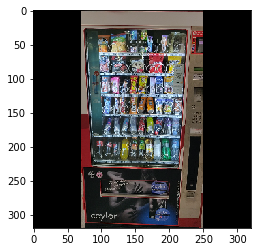

In [18]:
# for only the first image
images = []
gt_boxes = []
gt_classes = []
vidcap = cv2.VideoCapture("/content/gdrive/My Drive/Masterarbeit/ObjectDetection/Video/Smartphone/VID_20190430_110345.mp4")
success, image = vidcap.read()
objects = load_annotation("/content/gdrive/My Drive/Masterarbeit/ObjectDetection/Video/Smartphone/VID_20190430_110345.xml")
width, height = image.shape[:2]
M = cv2.getRotationMatrix2D((width / 2, width / 2), 270, 1.0)
image = cv2.warpAffine(image, M, (width, height))
prev_image = image
image_resized, objects = resize_padded_with_bndboxes(np.array(image), objects, 320)
img_rgb = cv2.cvtColor(image_resized.astype(np.uint8), cv2.COLOR_BGR2RGB)
images.append(img_rgb)
gt_boxes.append([[obj["bndbox"]["ymin"], obj["bndbox"]["xmin"],
                  obj["bndbox"]["ymax"], obj["bndbox"]["xmax"]] for obj in objects])
gt_classes.append([obj["id"] for obj in objects])
#show_img(draw_per_frame(img_rgb, gt_boxes[-1], gt_classes[-1])/255)
show_img(img_rgb/255)

#...

In [61]:
!pip install tensorflow-serving-api
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc
from time import time
import grpc
from tensorflow.contrib.util import make_tensor_proto

In [0]:
def setup_stub_gRPC(ip, port):
  channel = grpc.insecure_channel("{}:{}".format(ip,port))
  stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
  # Send request
  # See prediction_service.proto for gRPC request/response details.
  return stub

In [0]:
def predict_per_frame_gRPC(image, stub, image_form):
  request = predict_pb2.PredictRequest()
  request.model_spec.name = 'holoselecta'
  request.model_spec.signature_name = 'serving_default'
  tic = time()
  if image_form == 'image_tensor':
    image_data = image
    image_shape = [1] + list(image.shape)
  if image_form == 'encoded_image_string_tensor':
    image_data = cv2.imencode('.jpg', image)
    image_data = image_data[1].tostring()
    image_shape = [1]
  request.inputs['inputs'].CopyFrom(make_tensor_proto(image_data, shape=image_shape))
  result = stub.Predict(request, 20.0)  # 20 secs timeout
  toc = time()
  print("--> query time of {}s".format(toc-tic))
  return result

--> query time of 0.24135375022888184s


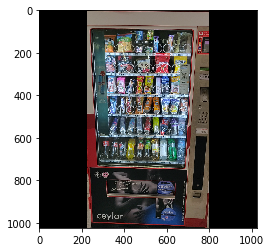

[0.9897860288619995, 0.9753459692001343, 0.9745234251022339, 0.9595873355865479, 0.9365843534469604, 0.9312173128128052, 0.898177981376648, 0.8341312408447266, 0.8152368664741516, 0.7851929664611816]
--> query time of 0.23034143447875977s
--> query time of 0.2246394157409668s
--> query time of 0.2283763885498047s
--> query time of 0.22826337814331055s
--> query time of 0.22702574729919434s


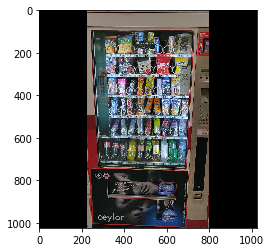

[0.989295482635498, 0.9864689111709595, 0.9854732751846313, 0.9825509190559387, 0.9778245091438293, 0.9672214984893799, 0.9227012991905212, 0.9208658933639526, 0.9016258120536804, 0.8945847153663635]
--> query time of 0.23698687553405762s
--> query time of 0.22942137718200684s
--> query time of 0.22734570503234863s
--> query time of 0.22728824615478516s
--> query time of 0.22911620140075684s


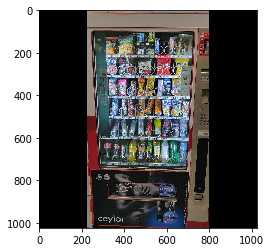

[0.9940972328186035, 0.9933440685272217, 0.9830142259597778, 0.9806176424026489, 0.9739969968795776, 0.9697195291519165, 0.964087724685669, 0.9523048400878906, 0.9159985184669495, 0.8974775075912476]
--> query time of 0.24248671531677246s
--> query time of 0.22702932357788086s
--> query time of 0.22907447814941406s
--> query time of 0.2282247543334961s
--> query time of 0.2278273105621338s


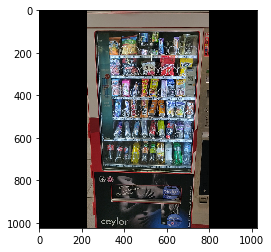

[0.9951106905937195, 0.9881807565689087, 0.9431573152542114, 0.9376795291900635, 0.9150316715240479, 0.9072906374931335, 0.899290919303894, 0.8831019401550293, 0.8707882165908813, 0.8376691341400146]
--> query time of 0.22920703887939453s


In [110]:
ip = "34.90.247.213"
port_grpc = "443"
stub = setup_stub_gRPC(ip, port_grpc)
  
p_boxes = []
p_classes = []
p_scores = []
for it, img in enumerate(images):
  results = predict_per_frame_gRPC(img, stub, 'encoded_image_string_tensor')
  boxes = results.outputs['detection_boxes'].float_val
  classes = results.outputs['detection_classes'].float_val
  scores = results.outputs['detection_scores'].float_val
  p_boxes.append(np.reshape(boxes,[int(len(scores)),4]).tolist())
  p_classes.append(np.reshape(classes,[int(len(scores)),1]).tolist())
  p_scores.append(np.reshape(scores,[int(len(scores)),1]).tolist())
  if it % 5 == 0:
    show_img(img)
    print(results.outputs['detection_scores'].float_val[0:10])

In [0]:
import pickle as pkl

pkl_var = {"video_file": "/content/gdrive/My Drive/Masterarbeit/ObjectDetection/Video/Smartphone/VID_20190430_110345.mp4",
           "fps": 6,
           "res": 320,
           "padded": True,
           "images":images,
           "Ts": Ts,
           "gt": {"boxes": gt_boxes,
                  "classes": gt_classes},
           "p": {"modelName": "retinanet_320_1000",
                 "boxes":p_boxes,
                 "classes":p_classes,
                 "scores":p_scores}}

with open("/content/gdrive/My Drive/Masterarbeit/ObjectDetection/FramePooling/retinanet_320_1000.pkl", "wb+") as file:
  pkl.dump(pkl_var, file)

#...

In [0]:

def calc_iou(box1, box2, width=320, height=320):
  # determine the (x, y)-coordinates of the intersection rectangle
  x1 = max(box1[1], box2[1]) 
  y1 = max(box1[0], box2[0]) 
  x2 = min(box1[3], box2[3]) 
  y2 = min(box1[2], box2[2])
  
  # compute the area of intersection rectangle
  interArea = max(0, x2 - x1) * max(0, y2 - y1)
  
  # compute the area of both the prediction and ground-truth
  # rectangles
  box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
  box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])
  
  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(box1Area + box2Area - interArea)

  # return the intersection over union value
  return iou

In [0]:
from sklearn.metrics import average_precision_score

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns


def calc_mAP_per_frame(gt_boxes, gt_classes, p_boxes, p_classes, p_scores, confidence_thresh = 0.5):
  
  results = []
  for box, clas, score in zip(p_boxes, p_classes, p_scores):
    results.append((box,clas,score))
  results.sort(key=lambda x: x[2], reverse=True)
  for it, result in enumerate(results):
    p_boxes[it] = result[0]
    p_classes[it] = result[1]
    p_scores[it] = result[2]
  
  mAP = {it/100.0: 0 for it in range(50,100,5)} 
  for iou_thresh in mAP.keys():
    selected = set()
    preds = [None] * len(p_scores)
    for itp, pb in enumerate(p_boxes):
      if p_scores[itp] < confidence_thresh:
        continue
      for itgt, gtb in enumerate(gt_boxes):
        if not itgt in selected:
          iou = calc_iou(gtb, pb)
          if iou > iou_thresh:
            if gt_classes[itgt] == p_classes[itp]:
              preds[itp] = "tp"
            else:
              preds[itp] = "fn"
            selected.add(itgt)
            break
    
    for itp, score in enumerate(p_scores):
      if preds[itp] is None and score > confidence_thresh:
        preds[itp] = "fp"
    
    preds = [pred for pred in preds if not pred is None]
        
    sum_tp = [0] * len(preds)
    sum_fn = [0] * len(preds)
    sum_fp = [0] * len(preds)
    recs  = [0.0] * len(preds)
    precs = [1.0] * len(preds)
    for it, pred in enumerate(preds):
      if it >= 1:
        sum_tp[it] = sum_tp[it-1]
        sum_fn[it] = sum_fn[it-1]
        sum_fp[it] = sum_fp[it-1]
      
      if pred == "tp":
        sum_tp[it] += 1
      elif pred == "fn":
        sum_fn[it] += 1
      elif pred == "fp":
        sum_fp[it] += 1
    
      precs[it] = sum_tp[it] / (sum_tp[it] + sum_fp[it])
      recs[it] = sum_tp[it] / len(preds)
    
    print(preds)
    print(["{:.4f}".format(prec) for prec in precs])
    print(["{:.4f}".format(rec) for rec in recs])
    
    sns.lineplot(recs, precs)
    plt.show()
    
    highpoint = 0
    highval = 0
    for it in range(len(precs), 1):
      if precs[it] > precs[it-1]:
        if precs[it] > highpoint:
          highval = precs[it]
          highpoint = it
      else:
        precs[highpoint:it:-1] = [highval] * (highpoint - it)
    
    sns.lineplot(recs, precs)
    plt.show()
    break
    
    #len(precs)
    
    
  print("mAP @ 0.5:      ", mAP[0.5])
  print("mAP @ 0.5:0.95: ", sum(list(mAP.values()))/len(mAP))

['tp', 'fn', 'fn', 'tp', 'tp', 'fn', 'tp', 'tp', 'tp', 'tp', 'tp', 'tp', 'tp', 'fp', 'fn', 'fp', 'fn', 'tp', 'fp', 'tp', 'fn']
['1.0000', '1.0000', '1.0000', '1.0000', '1.0000', '1.0000', '1.0000', '1.0000', '1.0000', '1.0000', '1.0000', '1.0000', '1.0000', '0.9091', '0.9091', '0.8333', '0.8333', '0.8462', '0.7857', '0.8000', '0.8000']
['0.0476', '0.0476', '0.0476', '0.0952', '0.1429', '0.1429', '0.1905', '0.2381', '0.2857', '0.3333', '0.3810', '0.4286', '0.4762', '0.4762', '0.4762', '0.4762', '0.4762', '0.5238', '0.5238', '0.5714', '0.5714']


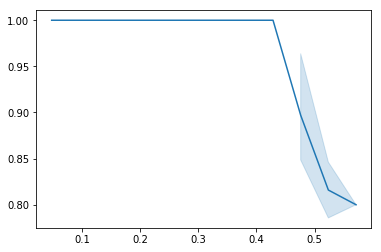

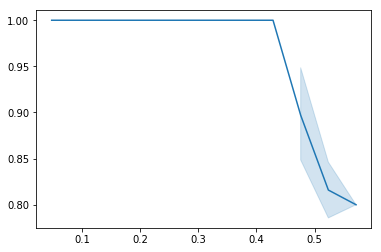

mAP @ 0.5:       0
mAP @ 0.5:0.95:  0.0


In [47]:
calc_mAP_per_frame(gt_boxes[0], gt_classes[0], p_boxes[0], p_classes[0], p_scores[0])

In [0]:
p_boxes = np.array(p_boxes)
p_classes = np.array(p_classes)
p_classes = p_classes.reshape(p_classes.shape[:-1])
p_scores = np.array(p_scores)
p_scores = p_scores.reshape(p_scores.shape[:-1])

In [72]:
pos = -1
img = draw_per_frame(images[pos],
                     [box for it,box in enumerate(p_boxes[pos]) if p_scores[pos][it] > 0.5],
                     [clas for it,clas in enumerate(p_classes[pos]) if p_scores[pos][it] > 0.5])
img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2BGR)
cv2.imwrite("tmp.png",img)

True

In [0]:
def transform_boxes(p_boxes, p_categories, p_scores, Ts):
  
  for it, t in enumerate(Ts):
    for image_it in range(0,it+1):
      for box in p_boxes[image_it]:
        pmin = np.array([box[1] * width, box[0] * height, 1])
        pmax = np.array([box[3] * width, box[2] * height, 1])
        pmin_n = np.dot(T,pmin)
        pmax_n = np.dot(T,pmax)
        box[1] = pmin_n[0] / width
        box[0] = pmin_n[1] / height
        box[3] = pmax_n[0] / width
        box[2] = pmax_n[1] / height
  
  return p_boxes

In [0]:
def frame_pooling(p_boxes, p_categories, p_scores, Ts, image_id, IoU=0.1):
  """Takes images, and predictions from consecutive frames
  and does mean pooling over the frames, returns the boxes 
  for the last frame
  """
  
  #find all non overlapping boxes (iou >= 0.2)
  results = []
  non_overlap = []
  overlap = []
  for it, boxes in enumerate(p_boxes):
    for bit, box1 in enumerate(boxes):
      if all([calc_iou(np.array(box1), np.array(box2["bbox"][0])) < IoU for box2 in results]):
        results.append({"bbox":[box1], "category_id":[p_categories[it][bit]], "score":[p_scores[it][bit]], "image_id":[it]})
      else:
        overlap.append({"bbox": box1, "category_id":p_categories[it][bit], "score":p_scores[it][bit], "image_id":it})
    
  #assign all boxes to the box with the largest overlap
  for box1 in overlap:
    ious = []
    for rit, box2 in enumerate(results):
      iou = calc_iou(np.array(box1["bbox"]), np.array(box2["bbox"][0]))
      if iou > IoU:
        ious.append((iou,rit))
    ious.sort(key=lambda x: x[0], reverse=True)         
    results[ious[0][1]]["bbox"].append(box1["bbox"])
    results[ious[0][1]]["category_id"].append(box1["category_id"])
    results[ious[0][1]]["score"].append(box1["score"])
    results[ious[0][1]]["image_id"].append(box1["image_id"])
      
  #per image and overlap keep only the one with the highest confidence
  #pool the predictions and take the highest as the predicted
  num_images = len(p_boxes)
  for box in results:
    top_confidence = [[]] * num_images
    for it, img_id in enumerate(box["image_id"]):
      top_confidence[img_id].append((box["bbox"][it],box["category_id"][it],box["score"][it]))
    top_sorted = [sorted(tc, key=lambda x: x[2], reverse=True)[0] for tc in top_confidence if len(tc) > 0]
    top_boxes = [ts[0] for ts in top_sorted]
    box["bbox"] = [sum([tb[0] for tb in top_boxes]) / len(top_boxes),
                   sum([tb[1] for tb in top_boxes]) / len(top_boxes),
                   sum([tb[2] for tb in top_boxes]) / len(top_boxes),
                   sum([tb[3] for tb in top_boxes]) / len(top_boxes)]
    
    top_category = {ts[1]:0 for ts in top_sorted}
    for ts in top_sorted:
      top_category[ts[1]] += ts[2] / num_images
      
    top_tuple = sorted([(key, val) for key, val in top_category.items()],key=lambda x: x[1], reverse=True)[0]
    box["category_id"] = top_tuple[0]
    box["score"] = top_tuple[1]
    box["image_id"] = image_id
    
  return results
  
  #p_boxes = []
  #p_classes = []
  #p_scores = []
  #for box in results:
  #  p_boxes.append(box["bbox"])
  #  p_classes.append(box["category_id"])
  #  p_scores.append(box["score"])
  #  
  #return p_boxes, p_classes, p_scores

In [0]:
import json
def create_eval_files(images, gt_boxes, gt_categories, results, filename, width, height):
  annotations = {"images":[], "annotations":[], "categories":[]}
  known_cats = set()
  for image_it in range(1, len(images)+1):
    annotations["images"].append({"filename":filename,
                                  "height":height,
                                  "width":width,
                                  "id":image_it})
    for bbit in range(0, len(gt_boxes[image_it-1])):
      cat_id = gt_categories[image_it-1][bbit]
      if not cat_id in known_cats:
        annotations["categories"].append({'supercategory': 'snack', 'id': cat_id, 'name': str(cat_id)})
        known_cats.add(cat_id)
      bbox = gt_boxes[image_it-1][bbit]
      annotations["annotations"].append({"image_id":image_it,
                                         "bbox":bbox,
                                         "category_id":cat_id,
                                         "id":len(annotations["annotations"])+1,
                                         "iscrowd":0,
                                         "segmentation":bbox,
                                         "area":abs(bbox[0] - bbox[2]) * abs(bbox[1] - bbox[3])})
      
  with open("annotations.json","w+") as file:
    json.dump(annotations, file)
  with open("results.json","w+") as file:
    json.dump(results, file)

In [127]:
import pickle as pkl
with open("/content/gdrive/My Drive/Masterarbeit/ObjectDetection/FramePooling/retinanet_320_1000.pkl", "rb") as file:
  pkl_vars = pkl.load(file)

p_boxes = np.array(pkl_vars["p"]["boxes"])
print(p_boxes.shape)
p_classes = np.array(pkl_vars["p"]["classes"])
p_classes = p_classes.reshape(p_classes.shape[:-1])
print(p_classes.shape)
p_scores = np.array(pkl_vars["p"]["scores"])
p_scores = p_scores.reshape(p_scores.shape[:-1])
print(p_scores.shape)
gt_boxes = pkl_vars["gt"]["boxes"]
gt_classes = pkl_vars["gt"]["classes"]
images = pkl_vars["images"]

(17, 100, 4)
(17, 100)
(17, 100)


In [128]:
p_boxes = transform_boxes(p_boxes, p_classes, p_scores, Ts)

print(p_boxes.shape)

(17, 100, 4)


In [107]:



results = []
for it in range(6, len(p_boxes)):
  results = frame_pooling(p_boxes[it-6:it],
                         p_classes[it-6:it],
                         p_scores[it-6:it],
                         Ts[it-6:it], it-5, 0.1)
  #results.extend(result)
  
  #p_boxes_fp, p_classes_fp, p_scores_fp = frame_pooling(p_boxes[it-6:it], p_classes[it-6:it], p_scores[it-6:it],
  #                       Ts[it-6:it], it-5, 0.1)
  
  #calc_mAP_per_frame(gt_boxes[it], gt_classes[it], p_boxes_fp, p_classes_fp, p_scores_fp)
  
  
  if it % 10 == 0:
    print("working on:", it)
    print(len(result))
  
#print(len(results))
#create_eval_files(images[6:], gt_boxes[6:], gt_classes[6:], results, "VID.jpg", 320, 320)

working on: 10
58
618


In [0]:
pos = 8

results = []
bxsl = p_boxes.tolist()
clsl = p_classes.tolist()
scrl = p_scores.tolist()
for it in range(0, len(p_boxes[pos])):
  results.append({"bbox":bxsl[pos][it],
                  "category_id":clsl[pos][it],
                  "score": scrl[pos][it],
                  "image_id": 1})

create_eval_files(images[pos:pos+1], gt_boxes[pos:pos+1], gt_classes[pos:pos+1], results, "VID.jpg", 320, 320)

In [130]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

cocoGt=COCO("annotations.json")
cocoDt=cocoGt.loadRes("results.json")

imgIds=sorted(cocoGt.getImgIds())

cocoEval = COCOeval(cocoGt,cocoDt,'bbox')
cocoEval.params.imgIds = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.042
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.142
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

# ...

In [0]:
import json
#!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
#!unzip -q annotations_trainval2014.zip
#!rm annotations_trainval2014.zip
val = json.load(open("/content/annotations/instances_val2014.json", 'r'))

#annotationsfile: ["images":[{"filename": , "height": , "width": , "id": },...],
#                  "annotations": [{"image_id": , "bbox": [ , , , ], "category_id": , "id": }, ...],
#                  "categories": [{"name": , "id": }, ...]]
#resultsfile: [{"image_id":42,"category_id":18,"bbox":[258.15,41.29,348.26,243.78],"score":0.236},...]

In [0]:
print([val.keys()])

[dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])]


In [0]:
print(type(val["images"]))

<class 'list'>


In [0]:
print(type(val["images"][0]))

<class 'dict'>


In [0]:
print(val["categories"][0])

{'supercategory': 'person', 'id': 1, 'name': 'person'}
